In [ ]:
!pip install pykeen

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!rm -r /content/spec_images/
!rm -r /content/__MACOSX

In [ ]:
from zipfile import ZipFile

with ZipFile('drive/MyDrive/spec_images_clean_whole_128freq.zip', 'r') as zObject:
    zObject.extractall()

In [ ]:
!mv /content/spec_images_clean_whole_128freq /content/spec_images

# **Copy data processing from SVM**

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt 
import torch

In [ ]:
DRIVE_PATH = 'drive/MyDrive'
SEED = 42

## **Data preparation**

In [ ]:
# participants_info
participants = pd.read_excel(
    os.path.join(DRIVE_PATH, 'PsychiatricDiscourse_participant.data.xlsx')
)

In [ ]:
# depression_only
depression_only = participants.loc[
    (participants['thought.disorder.symptoms'] == 0.) &
    (participants['depression.symptoms'] != 0.)

]
depression_only

,ID,group,diagnosis,sex,age,education.level,education.years,depression.symptoms,thought.disorder.symptoms
0,PD-001,patient,schizotypal.disorder,female,19.0,secondary,11,1,0
1,PD-002,patient,bipolar.affective.disorder,female,26.0,higher,17,1,0
3,PD-004,patient,borderline.personality.disorder,female,16.0,secondary,9,1,0
7,PD-008,patient,bipolar.affective.disorder,female,19.0,higher.unfinished,12,1,0
12,PD-013,patient,recurrent.depressive.disorder,female,20.0,higher.unfinished,12,1,0
...,...,...,...,...,...,...,...,...,...
262,PN-313,control,NaN,female,28.0,higher,17,2,0
265,PN-316,control,NaN,female,30.0,higher,16,2,0
268,PN-319,control,NaN,female,27.0,higher,19,1,0
269,PN-320,control,NaN,female,27.0,higher,18,3,0


In [ ]:
control_group = participants.loc[
    (participants['depression.symptoms'] == 0.) &
    (participants['thought.disorder.symptoms'] == 0.)
]

control_group

,ID,group,diagnosis,sex,age,education.level,education.years,depression.symptoms,thought.disorder.symptoms
2,PD-003,patient,schizotypal.disorder,female,17.0,secondary,10,0,0
4,PD-005,patient,schizotypal.disorder,female,19.0,secondary,11,0,0
5,PD-006,patient,borderline.personality.disorder,female,22.0,higher.unfinished,15,0,0
8,PD-009,patient,schizotypal.disorder,female,17.0,secondary,10,0,0
9,PD-010,patient,bipolar.affective.disorder,female,20.0,higher.unfinished,12,0,0
...,...,...,...,...,...,...,...,...,...
264,PN-315,control,NaN,female,37.0,ученая степень,17,0,0
266,PN-317,control,NaN,male,34.0,ученая степень,18,0,0
267,PN-318,control,NaN,female,31.0,higher,15,0,0
271,PN-322,control,NaN,female,41.0,vocational,13,0,0


## **Data processing**

In [ ]:
DRIVE_PATH = 'drive/MyDrive'
DATA_PATH = 'psychiatric.disorders.ML/wav files'

In [ ]:
from zipfile import ZipFile

with ZipFile(f'{DRIVE_PATH}/psychiatric.disorders.ML.zip', 'r') as zObject:
    zObject.extractall()

In [ ]:
df = pd.concat([depression_only, control_group])

df.drop(['education.level', 'diagnosis', 'thought.disorder.symptoms', 'group'], axis=1, inplace=True)
df.sex.replace(['female', 'male'], [0, 1], inplace=True)
df.age.fillna(df.age.mean(), inplace=True)
df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()

In [ ]:
# def get_patient_audio(row, data_folder=os.path.join(DRIVE_PATH, 'wav files'), return_uncomplete=False):
def get_patient_audio(row, data_folder='/content/psychiatric.disorders.ML/wav files', return_uncomplete=False):
    """
    Find patient's recordings
    """
    key = row.ID
    audio_files = []
    for filename in os.listdir(data_folder):
        if filename.find(key) != -1:
            audio_files.append(filename)
    return audio_files

df['audio'] = df.apply(get_patient_audio, axis=1)

# exclude patients with no recordings
df = df[df.audio.apply(len) > 0]

In [ ]:
df[df.audio.apply(len) > 3]

,ID,sex,age,education.years,depression.symptoms,audio
20,PD-022,0,-0.543967,12,0,"[PD-022-pic-1-adventure.wav, PD-022-instr-1-ch..."
266,PN-317,1,0.903763,18,0,"[PN-317-pic-1-sportsman.wav, PN-317-pers-1-pre..."


In [ ]:
len(df)

243

In [ ]:
df.sample(5)

,ID,sex,age,education.years,depression.symptoms,audio
51,PD-053,0,-0.543967,13,1,"[PD-053-pers-1-present.wav, PD-053-instr-1-cha..."
166,PN-036,0,-0.337149,15,2,"[PN-036-pers-1-present.wav, PN-036-instr-1-cha..."
68,PD-072,0,-0.440558,15,1,"[PD-072-instr-1-chair.wav, PD-072-pers-1-prese..."
28,PD-030,0,-0.854195,10,0,"[PD-030-instr-1-chair.wav, PD-030-pic-1-advent..."
60,PD-063,0,-0.750786,11,0,"[PD-063-pic-1-adventure.wav, PD-063-pers-1-pre..."


In [ ]:
df.reset_index(drop=True, inplace=True)
df['depressed'] = pd.Series(df['depression.symptoms'] != 0).astype(int)

In [ ]:
# Group recordings by domain

task_mapping = {
    'narrative': ['sportsman', 'adventure', 'winterday'], 
    'story': ['present', 'trip', 'party'], 
    'instruction': ['chair', 'table', 'bench']
}

def get_domain_audio(row, domain):
    files = []
    for topic in task_mapping[domain]:
        for file_name in row.audio:
            if file_name.find(topic) != -1:
                files.append(file_name)
                
    if len(files) > 1:
        print(files)
    # assert len(files) < 2
    return files[0] if len(files) else None
    
    
    
for domain in task_mapping:
    df[f'audio.{domain}'] = df.apply(get_domain_audio, axis=1, domain=domain)

['PD-022-pic-1-sportsman.wav', 'PD-022-pic-1-adventure.wav']
['PN-317-pic-1-sportsman.wav', 'PN-317-pic-1-sportsman-2.wav']
['PN-317-pers-1-present-2.wav', 'PN-317-pers-1-present.wav']
['PN-317-instr-1-bench-2.wav', 'PN-317-instr-1-bench.wav']


## **CNN-specific data processing**

In [ ]:
TRAIN, TEST, VAL = 'Train', 'Test', 'Val'

LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Run to create train/test/val dataframes with **distinct patients** in each

In [ ]:
from sklearn.model_selection import train_test_split

# Below we create new dataframes, with each row containig a link to
# audio fragment image of whole audio file
df_train_frag, df_test_frag = train_test_split(df, test_size=0.2, stratify=df['depression.symptoms'], random_state=SEED)
df_train_frag, df_val_frag = train_test_split(df_train_frag, test_size=0.1, stratify=df_train_frag['depression.symptoms'], random_state=SEED)


def get_patient_fragments(row):
    fragments = []
    for audio in row.audio:
        name_prefix = audio.split('.')[0]
        for filename in os.listdir('spec_images'):
            if filename.startswith(name_prefix):
                fragments.append(filename)
    return fragments

for df_split in [df_train_frag, df_test_frag, df_val_frag]:
    df_split['audio.fragment'] = df_split.apply(get_patient_fragments, axis=1)
    
# drop redundant columns
drop_cols = ['audio', 'audio.narrative', 'audio.story', 'audio.instruction']
df_train_frag.drop(drop_cols, axis=1, inplace=True)
df_test_frag.drop(drop_cols, axis=1, inplace=True)
df_val_frag.drop(drop_cols, axis=1, inplace=True)

# create copy with patient-fragments correspondence for future inference
df_train_all_fragments = df_train_frag.copy(deep=True)
df_test_all_fragments = df_test_frag.copy(deep=True)
df_val_all_fragments = df_val_frag.copy(deep=True)

# create dataframe row for each audio fragment
df_train_frag = df_train_frag.explode('audio.fragment', ignore_index=True)
df_test_frag = df_test_frag.explode('audio.fragment', ignore_index=True)
df_val_frag = df_val_frag.explode('audio.fragment', ignore_index=True)

dataframes = dict(zip([TRAIN, TEST, VAL], [df_train_frag, df_test_frag, df_val_frag]))
for df_label in [TRAIN, TEST, VAL]:
    dataframes[df_label] = dataframes[df_label]

Run to create train/test/val dataframes where **patients interfere**

In [ ]:
# from sklearn.model_selection import train_test_split

# df_frag = df.copy()
# df_frag['audio.fragment'] = df_frag.apply(get_patient_fragments, axis=1)

# drop_cols = ['audio', 'audio.narrative', 'audio.story', 'audio.instruction']
# df_frag = df_frag.explode('audio.fragment', ignore_index=True).drop(drop_cols, axis=1)

# df_train_frag, df_test_frag = train_test_split(df_frag, test_size=0.2, stratify=df_frag['depression.symptoms'], random_state=SEED)
# df_train_frag, df_val_frag = train_test_split(df_train_frag, test_size=0.1, stratify=df_train_frag['depression.symptoms'], random_state=SEED)

# dataframes = dict(zip([TRAIN, TEST, VAL], [df_train_frag, df_test_frag, df_val_frag]))
# for df_label in [TRAIN, TEST, VAL]:
#     dataframes[df_label] = dataframes[df_label]

Perform **random oversampling** until number of depressed and non-depressed patients is equal

In [ ]:
from imblearn.over_sampling import RandomOverSampler


def perform_oversampling(df, column_name):
    ros = RandomOverSampler(random_state=SEED)
    X_resamp, y_resamp = ros.fit_resample(df.drop(column_name, axis=1), df[column_name])
    res = X_resamp.merge(y_resamp, how='left', left_index=True, right_index=True)
    return res

dataframes[TRAIN] = perform_oversampling(df_train_frag, 'depressed')
dataframes[VAL] = perform_oversampling(df_val_frag, 'depressed')

In [ ]:
for domain, df_domain in dataframes.items():
    print(domain, '\n', df_domain['depression.symptoms'].value_counts())

Train 
 0    326
1    214
2     75
3     37
Name: depression.symptoms, dtype: int64
Test 
 0    89
1    39
2    12
3     6
Name: depression.symptoms, dtype: int64
Val 
 0    35
1    23
2     9
3     3
Name: depression.symptoms, dtype: int64


In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class AudioDataset(Dataset):
    def __init__(self, label_data_df, img_dir, transform=None, target_transform=None):
        self.label_data_df = label_data_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.label_data_df)
    def __getitem__(self, idx):
        label = self.label_data_df.iloc[idx]['depression.symptoms']
        depressed = self.label_data_df.iloc[idx]['depressed']
        img_name = self.label_data_df.iloc[idx]['audio.fragment']
        img_path = os.path.join(self.img_dir, img_name)
        img = read_image(img_path)
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            img = self.target_transform(img)
        patient_meta = torch.tensor(self.label_data_df.loc[:,['sex', 'age']].iloc[idx]).type(torch.float32)
        return img, patient_meta, label, depressed

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Grayscale(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
    ]),
    TEST: transforms.Compose([
        transforms.Grayscale(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
    ]),
    VAL: transforms.Compose([
        transforms.Grayscale(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
    ]),
}

datasets = {
    TRAIN: AudioDataset(dataframes[TRAIN], 'spec_images', transform=data_transforms[TRAIN]), 
    TEST: AudioDataset(dataframes[TEST], 'spec_images', transform=data_transforms[TEST]), 
    VAL: AudioDataset(dataframes[VAL], 'spec_images', transform=data_transforms[VAL])
}

TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

rng = torch.Generator().manual_seed(SEED)
dataloaders = {
    TRAIN: DataLoader(datasets[TRAIN], TRAIN_BATCH_SIZE, shuffle=True, generator=rng), 
    TEST: DataLoader(datasets[TEST], TEST_BATCH_SIZE, shuffle=True, generator=rng),
    VAL: DataLoader(datasets[VAL], VAL_BATCH_SIZE, shuffle=True, generator=rng)
}

dataset_sizes = {
    TRAIN: len(datasets[TRAIN]), 
    TEST: len(datasets[TEST]),
    VAL: len(datasets[VAL]) 
}

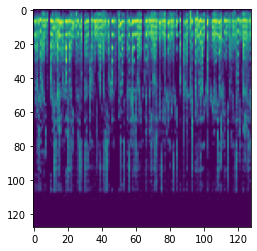

In [ ]:
import matplotlib.pyplot as plt

it = iter(datasets[TRAIN])
img = next(it)[0]
img2 = next(it)[0]
img3 = next(it)[0]
plt.imshow(transforms.ToPILImage()(img3))

## **Cifar10 Data Processing**

Defined exactly as for spectrograms with minor changes

In [ ]:
!rm -r /content/data/

In [ ]:
len(trainset)

50000

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((80, 80)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
trainset, valset = random_split(trainset, [47500, 2500])

datasets = {
    TRAIN: trainset, 
    TEST: testset, 
    VAL: valset
}

TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

rng = torch.Generator().manual_seed(SEED)
dataloaders = {
    TRAIN: DataLoader(datasets[TRAIN], TRAIN_BATCH_SIZE, shuffle=True, generator=rng), 
    TEST: DataLoader(datasets[TEST], TEST_BATCH_SIZE, shuffle=True, generator=rng),
    VAL: DataLoader(datasets[VAL], VAL_BATCH_SIZE, shuffle=True, generator=rng)
}

dataset_sizes = {
    TRAIN: len(datasets[TRAIN]), 
    TEST: len(datasets[TEST]),
    VAL: len(datasets[VAL]) 
}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
it = iter(dataloaders[TRAIN])
next(it)[0].shape

torch.Size([8, 1, 80, 80])

# **Model Training**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DCNN(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(1, 32, [7, 1]),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d([4, 3], stride=[1, 3]),

            nn.Conv2d(32, 64, [7, 1], stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d([1, 3]),
        )
        self.meta_features_ = nn.Sequential(
            nn.Linear(2, 16)
        )
        self.mixed_features_ = nn.Sequential(
            nn.Linear(101248 + 16, 256), 
            nn.Linear(256, 64), 
            nn.Dropout(p=0.5),
            nn.Linear(64, output_dim), 
            # nn.Sigmoid() # for BCELoss
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, images, meta):
        images = self.image_features_(images)
        images = torch.flatten(images, 1) # flatten all dimensions except batch
        meta = self.meta_features_(meta)
        mixed = torch.cat((images, meta), 1)
        mixed = self.mixed_features_(mixed)
        return mixed


class DCNN2(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(1, 32, [5, 5]),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d([2, 2], stride=[2, 2]),

            nn.Conv2d(32, 64, [5, 5]),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d([2, 2], stride=[2, 2]),
        )
        self.meta_features_ = nn.Sequential(
            nn.Linear(2, 16)
        )
        self.mixed_features_ = nn.Sequential(
            nn.Linear(53824 + 16, 256), 
            nn.Linear(256, 64), 
            nn.Dropout(p=0.5),
            nn.Linear(64, output_dim), 
            # nn.Sigmoid() # for BCELoss
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, images, meta):
        images = self.image_features_(images)
        images = torch.flatten(images, 1) # flatten all dimensions except batch
        meta = self.meta_features_(meta)
        mixed = torch.cat((images, meta), 1)
        mixed = self.mixed_features_(mixed)
        return mixed


class DCNNCifar(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(1, 32, [5, 5]),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d([2, 2], stride=[2, 2]),

            nn.Conv2d(32, 64, [5, 5]),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d([2, 2], stride=[2, 2]),
        )
        self.mixed_features_ = nn.Sequential(
            nn.Linear(18496, 256), 
            nn.Linear(256, 64), 
            nn.Dropout(p=0.5),
            nn.Linear(64, output_dim), 
            # nn.Sigmoid() # for BCELoss
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, images):
        images = self.image_features_(images)
        images = torch.flatten(images, 1) # flatten all dimensions except batch
        mixed = self.mixed_features_(images)
        return mixed


class DCNNTest(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(1, 32, [5, 5], stride=[1, 1]),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d([2, 2], stride=[2, 2]),

            nn.Conv2d(32, 64, [5, 5], stride=[1, 1]),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d([2, 2], stride=[2, 2]),
        )
        self.meta_features_ = nn.Sequential(
            nn.Linear(2, 16)
        )
        self.mixed_features_ = nn.Sequential(
            nn.Linear(53824 + 16, 512), 
            nn.Dropout(p=0.2),
            nn.Linear(512, 256), 
            nn.Dropout(p=0.2),
            nn.Linear(256, 64),
            nn.Dropout(p=0.2), 
            nn.Linear(64, output_dim), 
            # nn.Sigmoid() # for BCELoss
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, images, meta):
        images = self.image_features_(images)
        images = torch.flatten(images, 1) # flatten all dimensions except batch
        meta = self.meta_features_(meta)
        mixed = torch.cat((images, meta), 1)
        mixed = self.mixed_features_(mixed)
        return mixed

Convolution-transfomed image vs original and shapes within convolution layers

torch.Size([4, 1, 128, 128])
torch.Size([4, 32, 122, 128])
torch.Size([4, 32, 119, 42])
torch.Size([4, 32, 57, 21])
torch.Size([4, 32, 57, 7])


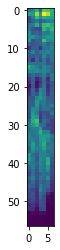

In [ ]:
it = iter(dataloaders[TRAIN])
imgs = next(it)[0]
print(imgs.shape)

conv = nn.Conv2d(1, 32, [7, 1], stride=1)
conv_img = conv(imgs)
print(conv_img.shape)

pool = nn.MaxPool2d([4, 3], stride=[1, 3])
pool_img = pool(conv_img)
print(pool_img.shape)

conv2 = nn.Conv2d(32, 32, [7 ,1], stride=2)
conv2_img = conv2(pool_img)
print(conv2_img.shape)

pool2 = nn.MaxPool2d([1, 3])
pool2_img = pool2(conv2_img)
print(pool2_img.shape)
plt.imshow(transforms.ToPILImage()(pool2_img[0][5]));

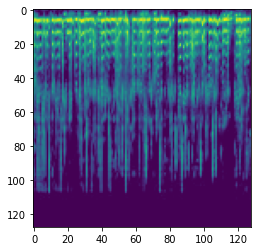

In [ ]:
plt.imshow(transforms.ToPILImage()(imgs[0]));

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
from collections import defaultdict
import time
import copy
from IPython.display import clear_output
from tqdm import tqdm


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    patience = 3
    trigger_cnt = 0
    prev_val_loss = 100.0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    best_acc = 0

    avg_loss = 0
    avg_acc = 0

    metrics = defaultdict(list)

    batch_num = {
        TRAIN: len(dataloaders[TRAIN]), 
        VAL: len(dataloaders[VAL])
    } 
  
    for epoch in tqdm(range(num_epochs)):
        metrics['Epoch'].append(epoch)

        for stage in [TRAIN, VAL]:
            model.train(stage == TRAIN)

            loss_epoch = 0
            acc_epoch = 0
      
            with torch.set_grad_enabled(stage == TRAIN):
                for i, data in enumerate(dataloaders[stage]):
                    print("\r Batch {}/{}".format(i, batch_num[stage]), end='', flush=True)
                        
                    # images, labels = data
                    images, meta, labels, depressed = data

                    # For binary
                    # labels = depressed

                    images = images.to(DEVICE)
                    meta = meta.to(DEVICE)
                    labels = labels.to(DEVICE)
                    
                    outputs = model(images, meta)
                    # outputs = model(images)

                    # For HuberLoss
                    if isinstance(criterion, nn.HuberLoss):
                        preds = torch.flatten(torch.round(outputs))
                        outputs = torch.flatten(outputs).to(torch.float32)
                        labels = labels.to(torch.float32)

                    # For CrossEntropy
                    if isinstance(criterion, nn.CrossEntropyLoss):
                        preds = torch.argmax(outputs, dim=1)

                    # For BCELoss
                    if isinstance(criterion, nn.BCELoss):
                        preds = torch.flatten(torch.round(outputs))
                        outputs = torch.flatten(outputs).to(torch.float32)
                        labels = labels.to(torch.float32)

                    loss = criterion(outputs, labels)
                    
                    if stage == TRAIN:
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                    loss_epoch += loss.data.item()
                    acc_epoch += torch.sum(preds == labels.data).item()
                    
                    del images, meta, labels, outputs, preds
                    # del images, labels, outputs, preds
                    torch.cuda.empty_cache()

            if stage == TRAIN:
                scheduler.step()
            
            avg_loss = loss_epoch / dataset_sizes[stage]
            avg_acc = acc_epoch / dataset_sizes[stage]

            if stage == VAL:
                if avg_loss <= best_loss:
                    best_acc = avg_acc
                    best_loss = avg_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if prev_val_loss <= avg_loss:
                    trigger_cnt += 1
                    print('Trigger', trigger_cnt)
                else:
                    trigger_cnt = 0
                    print('Trigger', trigger_cnt)
                prev_val_loss = avg_loss
                   
            metrics[f'{stage.title()} loss'].append(avg_loss)
            metrics[f'{stage.title()} acc'].append(avg_acc)

        clear_output(wait=True)
        display(pd.DataFrame(metrics))
    
        if trigger_cnt == patience:
            break

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, best_acc

In [ ]:
import torch

torch.cuda.empty_cache()
print(torch.cuda.memory_reserved(), torch.cuda.memory_allocated(), torch.cuda.memory_cached())

0 0 0


/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [ ]:
from torch.optim import Adam, SGD, lr_scheduler
# from pykeen.losses import FocalLoss

dcnn = DCNN2(output_dim=4).to(DEVICE)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
# criterion = nn.MSELoss() 
# criterion = nn.HuberLoss()
# criterion = FocalLoss(gamma=0.7)
optimizer_ft = Adam(dcnn.parameters(), lr=LR, weight_decay=0.0002)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

model_res = train_model(dcnn, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

,Epoch,Train loss,Train acc,Val loss,Val acc
0,0,38.416017,0.403374,0.740053,0.400000
1,1,19.650915,0.386503,0.705119,0.385714
2,2,9.208421,0.404908,0.267988,0.457143
3,3,4.804658,0.503067,0.333785,0.328571
4,4,2.736403,0.503067,0.390273,0.471429
5,5,1.285180,0.564417,0.269430,0.428571
6,6,0.984842,0.576687,0.211328,0.214286
7,7,0.793978,0.588957,0.118158,0.357143
8,8,0.606043,0.611963,0.197799,0.300000
9,9,0.513684,0.651840,0.121524,0.342857


100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


Training completed in 1m 43s
Best acc: 0.4429


In [ ]:
dcnn2 = DCNN(output_dim=4).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(dcnn2.parameters(), lr=LR, weight_decay=0.0002)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

model_res2 = train_model(dcnn2, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

,Epoch,Train loss,Train acc,Val loss,Val acc
0,0,7.698135,0.432615,0.466690,0.287815
1,1,2.077346,0.530462,0.275336,0.449580
2,2,0.716002,0.618154,0.216499,0.371849
3,3,0.301628,0.708615,0.174175,0.315126
4,4,0.153557,0.773231,0.118980,0.371849
5,5,0.077373,0.838154,0.133414,0.340336
6,6,0.054871,0.876923,0.125412,0.359244
7,7,0.044015,0.893846,0.099406,0.325630
8,8,0.038560,0.907077,0.120692,0.357143
9,9,0.033824,0.922462,0.134827,0.327731


 95%|█████████▌| 19/20 [04:02<00:12, 12.74s/it]


Training completed in 4m 2s
Best acc: 0.3256


In [ ]:
dcnn3 = DCNN(output_dim=4).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(dcnn3.parameters(), lr=LR, weight_decay=0.0002)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

model_res2 = train_model(dcnn3, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

,Epoch,Train loss,Train acc,Val loss,Val acc
0,0,8.646026,0.424308,0.778420,0.546218
1,1,2.211636,0.542769,0.401483,0.470588
2,2,0.739737,0.652615,0.263576,0.245798
3,3,0.357016,0.717846,0.216979,0.222689
4,4,0.166790,0.801231,0.189262,0.371849
5,5,0.077066,0.851692,0.153261,0.344538
6,6,0.061711,0.870154,0.152146,0.304622
7,7,0.049128,0.893231,0.139944,0.306723
8,8,0.039791,0.904308,0.171531,0.313025
9,9,0.032980,0.927385,0.149643,0.281513


 95%|█████████▌| 19/20 [04:18<00:13, 13.59s/it]


Training completed in 4m 18s
Best acc: 0.3067


## **Grid search hyperparameters**

In [ ]:
from torch.optim import Adam, lr_scheduler

from itertools import product


grid = {
    'lr': [1e-2, 1e-3], 
    'weight_decay': [0.001, 0.0005, 0.0002], 
    'criterion': [nn.CrossEntropyLoss, nn.HuberLoss]
}

def grid_search(*args, **kwargs):
    criterion = kwargs.pop('criterion')()
    output_dim = 1 if isinstance(criterion, nn.HuberLoss) else 4

    model = DCNN2(output_dim).to(DEVICE)
    optimizer_ft = Adam(model.parameters(), **kwargs)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)

    return train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

models = []
for kwargs in product(*grid.values()):
    print("LR: {:.4f}; weight decay: {:.4f}; criterion: {}".format(kwargs[0], kwargs[1], kwargs[2].__name__))
    model, best_acc = grid_search(**dict(zip(grid.keys(), kwargs)))
    models.append({
        'Model': model, 
        'Best Acc': best_acc,
        'LR': kwargs[0], 
        'Weight Decay': kwargs[1], 
        'Criterion': kwargs[2].__name__
    })

,Epoch,Train loss,Train acc,Val loss,Val acc
0,0,0.262413,0.214153,0.010296,0.301003
1,1,0.057310,0.344413,0.007437,0.352007
2,2,0.043234,0.416853,0.007059,0.331104
3,3,0.034672,0.477095,0.005544,0.390468
4,4,0.027413,0.545345,0.005307,0.428930
5,5,0.021711,0.602328,0.005720,0.380435
6,6,0.017553,0.659870,0.004620,0.474080
7,7,0.010854,0.784358,0.004616,0.454013
8,8,0.009331,0.813408,0.005291,0.423077
9,9,0.008460,0.831657,0.004743,0.468227


 85%|████████▌ | 17/20 [11:26<02:01, 40.39s/it]


Training completed in 11m 27s
Best acc: 0.4682


In [ ]:
models

[{'Model': DCNN2(
    (image_features_): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=[4, 3], stride=[1, 3], padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=[1, 3], stride=[1, 3], padding=0, dilation=1, ceil_mode=False)
    )
    (meta_features_): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
    )
    (mixed_features_): Sequential(
      (0): Linear(in_features=33296, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=64, bias=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=4, bias=True)
    )
  ),
  'Best Acc': 0.6362876254180602

In [ ]:
max_acc = max(map(lambda x: x['Best Acc'], models))
best_model = list(filter(lambda x: x['Best Acc'] == max_acc, models))[0]
best_model

{'Model': DCNN2(
   (image_features_): Sequential(
     (0): Conv2d(1, 32, kernel_size=(7, 1), stride=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=[4, 3], stride=[1, 3], padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1))
     (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): MaxPool2d(kernel_size=[1, 3], stride=[1, 3], padding=0, dilation=1, ceil_mode=False)
   )
   (meta_features_): Sequential(
     (0): Linear(in_features=2, out_features=16, bias=True)
   )
   (mixed_features_): Sequential(
     (0): Linear(in_features=33296, out_features=256, bias=True)
     (1): Linear(in_features=256, out_features=64, bias=True)
     (2): Dropout(p=0.5, inplace=False)
     (3): Linear(in_features=64, out_features=4, bias=True)
   )
 ),
 'Best Acc': 0.7483277591973244,
 'LR': 0.001,
 'Weig

# **Evaluations**

In [ ]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.eval()

        images, meta, labels, depressed = data
        # images, labels = data
        images = images.to(DEVICE)
        meta = meta.to(DEVICE)
        labels = labels.to(DEVICE)
        depressed = depressed.to(DEVICE)
            
        with torch.no_grad():
            outputs = model(images, meta)
            # outputs = model(images)

        # For HuberLoss
        if isinstance(criterion, nn.HuberLoss):
            preds = torch.flatten(torch.round(outputs))
            outputs = torch.flatten(outputs).to(torch.float32)
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)

        # For CrossEntropy
        if isinstance(criterion, nn.CrossEntropyLoss):
            preds = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)

        # For BCELoss
        if isinstance(criterion, nn.BCELoss):
            preds = torch.flatten(torch.round(outputs))
            outputs = torch.flatten(outputs).to(torch.float32)
            depressed = depressed.to(torch.float32)
            loss = criterion(outputs, depressed)


        loss_test += loss.data.item()
        acc_test += torch.sum(preds == labels.data)

        del images, meta, labels, outputs, preds
        # del images, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
eval_model(dcnn, nn.CrossEntropyLoss())

Evaluating model
----------
Test batch 2/3
Evaluation completed in 0m 1s
Avg loss (test): 0.0546
Avg acc (test): 0.5616
----------


In [ ]:
def maj_vote(outputs):
    counts = np.bincount(outputs)
    # if more than one value is selected by majj vote return mean value
    if np.count_nonzero(counts == np.max(counts)) > 1:
        return np.rint(np.mean(outputs)).astype(int)
    # else return value given by maj vote
    else:
        return np.argmax(counts)


def predict_ensemble(data, *models):
    images, meta = data

    with torch.no_grad():
        all_outputs = np.array([model(images, meta).data.cpu().numpy() for model in models])

    all_preds = np.argmax(all_outputs, axis=2)
    all_preds = np.swapaxes(all_preds, 0, 1)
    groupped_preds = np.apply_along_axis(maj_vote, axis=1, arr=all_preds)
    groupped_preds = torch.flatten(torch.tensor(groupped_preds)).to(DEVICE)

    return groupped_preds


def eval_ensemble(*models, metrics=[]):
    assert metrics, "Specify metrics to calculate"

    since = time.time()

    y_true, y_pred = [], []
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        for model in models:
            model.eval()

        images, meta, labels, depressed = data
        images, meta = map(lambda x: x.to(DEVICE), [images, meta])
        
        groupped_preds = predict_ensemble((images, meta), *models).cpu().numpy()

        y_pred.extend(groupped_preds)
        y_true.extend(labels)

        del images, meta, labels, groupped_preds
        torch.cuda.empty_cache()
        
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    for metric in metrics:
        print("{}: {:.4f}".format(metric.__name__, metric(y_true, y_pred)))
    print('-' * 10)

Run to look at how outputs differ from model to model

In [ ]:
predict_batches = 1

dataloader_iter = iter(dataloaders[TEST])
dcnn.eval()
for _ in range(predict_batches):
    images, meta, labels, depressed = next(dataloader_iter)
    images, meta, labels, depressed = map(lambda x: x.to(DEVICE), [images, meta, labels, depressed])
    with torch.no_grad():
        # HuberLoss
        # preds = torch.flatten(torch.round(dcnn(images, meta))).type(torch.int)

        # CrossEntropy
        preds = torch.argmax(dcnn(images, meta), dim=1)
        # preds2 = torch.argmax(dcnn2(images, meta), dim=1)
        # preds3 = torch.argmax(dcnn3(images, meta), dim=1)

        # BCELoss
        # preds = torch.flatten(torch.round(dcnn(images, meta))).type(torch.int)
    print(preds)
    # print(preds2)
    # print(preds3)
    print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 3, 1,
        0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 3, 0], device='cuda:0')


In [ ]:
class FragmentAudioDataset(Dataset):
    def __init__(self, label_data_df, img_dir, transform=None, target_transform=None):
        self.label_data_df = label_data_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.label_data_df)
    def __getitem__(self, idx):
        """
        Return all fragments for each participant
        """
        label = self.label_data_df.iloc[idx]['depression.symptoms']
        depressed = self.label_data_df.iloc[idx]['depressed']
        frag_names = self.label_data_df.iloc[idx]['audio.fragment']

        # create array with data for all fragments [(img, meta), ,(...)]
        frag_data = []
        for frag_name in frag_names:
            frag_path = os.path.join(self.img_dir, frag_name)
            frag_img = read_image(frag_path)
            if self.transform:
                frag_img = self.transform(frag_img)
            frag_meta = torch.tensor(self.label_data_df.loc[:,['sex', 'age']].iloc[idx]).type(torch.float32)
            frag_data.append((frag_img, frag_meta))
        
        if self.target_transform:
            label = self.target_transform(label)

        return frag_data, label, depressed

In [ ]:
all_fragments_test_dataset = FragmentAudioDataset(
    df_test_all_fragments, 
    'spec_images', 
    transform=data_transforms[TEST]
)

all_fragments_test_dataloader = DataLoader(
    all_fragments_test_dataset, 
    batch_size=1, # setting to value other than 1 will lead to an error
    batch_sampler=None
)

In [ ]:
def eval_ensemble_all_fragments(*models):
    since = time.time()
    avg_acc = 0
    acc_test = 0
    
    test_batches = len(all_fragments_test_dataloader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(all_fragments_test_dataloader):
        print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        for model in models:
            model.eval()

        frag_data, label, depressed = data
        label, depressed = map(lambda x: x.to(DEVICE), [label, depressed])

        frag_preds = []
        for frag_img, frag_meta in frag_data:
            frag_img, frag_meta = map(lambda x: x.to(DEVICE), [frag_img, frag_meta])
            frag_pred = predict_ensemble((frag_img, frag_meta), *models)
            frag_preds.append(frag_pred.item())
        audio_pred = torch.tensor(maj_vote(frag_preds)).to(DEVICE)
        
        acc_test += torch.sum(audio_pred == label.data)

        del frag_img, frag_meta, label, audio_pred
        torch.cuda.empty_cache()
        
    avg_acc = acc_test / test_batches
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
eval_ensemble_all_fragments(dcnn, dcnn2, dcnn3)

Evaluating model
----------
Test batch 17/18
Evaluation completed in 0m 4s
Avg acc (test): 0.4444
----------


## **Calculate stats**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


def plot_confusion(*models):
    y_pred = []
    y_true = []

    # fill true and pred arrays
    for images, meta, labels, depressed in dataloaders[TEST]:
        images, meta, labels, depressed = map(lambda x: x.to(DEVICE), 
                                              [images, meta, labels, depressed])

        preds = predict_ensemble((images, meta), *models)
        preds = preds.data.cpu().numpy()
        y_pred.extend(preds)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

    classes = (0, 1, 2, 3)

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 100) 
    ax = plt.subplot()
    sn.heatmap(df_cm, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')

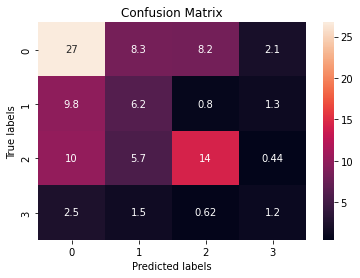

In [ ]:
plot_confusion(dcnn, dcnn2, dcnn3)

In [ ]:
from functools import partial, update_wrapper
from sklearn.metrics import accuracy_score, precision_score, f1_score
from imblearn.metrics import specificity_score


def wrapped_partial(func, *args, **kwargs):
    """
    Helps initialize function's parameters and keep dunder attributes 
    when passed to subsequent functions
    """
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func


accuracy = wrapped_partial(accuracy_score)
precision = wrapped_partial(precision_score, average='weighted')
f1 = wrapped_partial(f1_score, average='weighted')
specificity = wrapped_partial(specificity_score, average='weighted')

# plug_eval(metrics=[accuracy, precision, f1, specificity])
eval_ensemble(dcnn, dcnn2, dcnn3, metrics=[accuracy, precision, f1, specificity])

Evaluating model
----------
Test batch 70/71
Evaluation completed in 0m 3s
accuracy_score: 0.4850
precision_score: 0.4956
f1_score: 0.4869
specificity_score: 0.7338
----------
